In [1]:

import numpy as np
import datetime as dt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error,root_mean_squared_error,mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import sklearn
import matplotlib.pyplot as plt
import customFunctions as fct

scaler=StandardScaler()

In [2]:
# Read in the data using the simple reading and cleaning function
data_ERA5 = fct.read_ts_csv(f'reanalysis.csv')
data_LIDAR = fct.read_ts_csv(f'measurements/lidar.csv')

# Resample the data to 1h intervals
data_ERA5 = data_ERA5.resample('h', on='Time').mean()
data_LIDAR = data_LIDAR.resample('h', on='Time').mean()

# create a merged dataframe containing the ERA5 and the LIDAR data
data_mrgd = pd.merge(data_LIDAR, data_ERA5, how='right', on='Time')

# Ensure that the datetime format is used for the datetime index
data_mrgd.index = pd.to_datetime(data_mrgd.index)

data_mrgd['Mon']      = data_mrgd.index.strftime('%m')
data_mrgd['Hour']     = data_mrgd.index.strftime('%H')
data_mrgd.tail()



,WS-99.2,WD-99.2,WS100,WD100,Mon,Hour
Time,,,,,,
2024-12-31 19:00:00,NaN,NaN,21.859,225.5,12,19
2024-12-31 20:00:00,NaN,NaN,21.991,226.8,12,20
2024-12-31 21:00:00,NaN,NaN,22.290,228.4,12,21
2024-12-31 22:00:00,NaN,NaN,21.714,228.1,12,22
2024-12-31 23:00:00,NaN,NaN,22.628,227.7,12,23


In [6]:
# Preparation
# set hyperparameters for ML-model
import sklearn.gaussian_process
import sklearn.neighbors
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared


param_grid_RadiusNeighborsRegressor = {
              "radius"            : np.arange(0.1, 1, .1),
              "leaf_size"         : np.arange(1, 10, 1),
              "p"                 : [1],
              "weights"           : ['uniform', 'distance'],
              "metric"            : ['euclidean','manhattan','minkowski'] 
             }

param_grid_KNeighbors = {
              "n_neighbors"       : [2,5,12,30],
              "leaf_size"         : [1, 2, 3,15,30],
              "p"                 : [1,2],
              "weights"           : ['uniform', 'distance'],
              "metric"            : ['euclidean','manhattan','minkowski'] 
             }

param_grid_LinReg = {
            "fit_intercept"     : [False, True],
            "copy_X"            : [False, True]
}

# Define kernels:
ker_rbf = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")

# ker_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)

# ker_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))

kernel_list = [ker_rbf]

param_grid_Gaussian = {
            "kernel"    : kernel_list, # ['ExpSineSquared', 'ConstantKernel', 'WhiteKernel']
            "alpha"     : np.arange(4, 5, 0.1) * 10 ** -10,
            "optimizer" : ['fmin_l_bfgs_b']
}

# chose which ML model to use (e.g. linear regression, random Forest, Decision tree, AdaBoost, XGBoost, Ridge regression, )
# check sklearn + model for correct naming and more information)
# consider to import the packages before

# classifier = sklearn.linear_model.LinearRegression()
classifier = KNeighborsRegressor()
# Randomforest, 
# classifier = sklearn.neighbors.RadiusNeighborsRegressor()
# classifier = sklearn.gaussian_process.GaussianProcessRegressor()

In [7]:
predictions, valid_values = fct.correct_long_term_wind(data_mrgd[['WS100','WD100','Mon','Hour']], data_mrgd['WS-99.2'], classifier=classifier, param_grid=param_grid_KNeighbors)

Best score:
-1.38
Best parameters:
{'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Validation scores - Cross Validation:
-------------------------
R2-Score:  0.9342
MSE:  1.3357
RMSE:  1.1557
MAE:  0.8448
MAPE:  13.0987
Validation scores - Without Correction:
-------------------------
R2-Score:  0.9238
MSE:  1.5719
RMSE:  1.2537
MAE:  0.9267
MAPE:  13.6171
Validation scores - Model and Test Data:
-------------------------
R2-Score:  0.9401
MSE:  1.2785
RMSE:  1.1307
MAE:  0.8163
MAPE:  12.2684


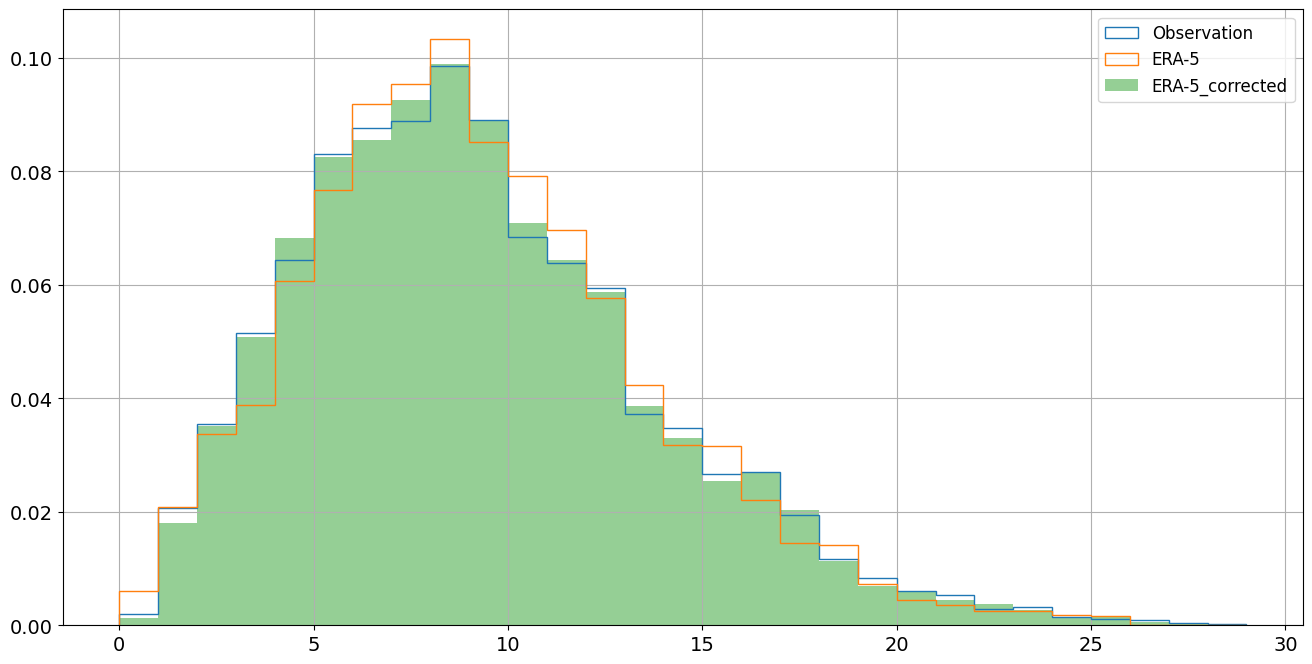

In [9]:
nbins = np.arange(0, 30, 1)

fig = plt.figure(figsize=(16,8))
plt.hist(data_mrgd['WS-99.2'].iloc[valid_values], nbins, label='Observation', histtype='step', density=True)
plt.hist(data_mrgd['WS100'].iloc[valid_values], nbins, label='ERA-5', histtype='step', density=True)
plt.hist(predictions[valid_values], nbins, label='ERA-5_corrected', alpha=0.5, density=True)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.legend(fontsize= 12)
plt.grid()